# MNIST neural network from scratch

Only using packages I truly don't want to replicate, like pandas, numpy, tf and etc.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

2023-01-28 20:40:35.598181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parse data

In [2]:
mnist_data = mnist.load_data()

In [3]:
(train_X, train_y), (test_X, test_y) = mnist_data

train_X, val_X, train_y, val_y =  train_test_split(train_X, train_y, test_size=0.25)

train_X = train_X.reshape(train_X.shape[0], -1) / 255.
train_y = tf.one_hot(train_y, depth=10)

val_X = val_X.reshape(val_X.shape[0], -1) / 255.
val_y = tf.one_hot(val_y, depth=10)

test_X = test_X.reshape(test_X.shape[0], -1) / 255.
test_y = tf.one_hot(test_y, depth=10)

2023-01-28 20:40:40.154014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print('Training features shape: ', train_X.shape)
print('Training labels shape: ', train_y.shape)

print('Validation features shape: ', val_X.shape)
print('Validation labels shape: ', val_y.shape)

print('Testing examples shape: ', test_X.shape)
print('Testin labels shape: ', test_y.shape)

Training features shape:  (45000, 784)
Training labels shape:  (45000, 10)
Validation features shape:  (15000, 784)
Validation labels shape:  (15000, 10)
Testing examples shape:  (10000, 784)
Testin labels shape:  (10000, 10)


## Define helper functions

In [21]:
def getActivationDerivative(activation):
    if activation == 'linear':
        return lambda x : np.ones(x.shape)

    if activation == 'relu':
        return lambda x : x > 0
    
    if activation == 'sigmoid':
        g = tf.keras.activations.sigmoid
        return lambda x : g(x) * (1 - g(x))
    
def printProgressBar(progress):
    maxLen = 40
    markerIncomplete = "-"
    markerComplete = "="
    currentIndex = math.ceil(progress * maxLen)
    return markerComplete * currentIndex + ">" + markerIncomplete * (maxLen - currentIndex)

## Write _Dense_ and _Sequential_ (mimic TensorFlow)

In [22]:
class Dense:
    def __init__(self, units, activation=None):
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.activationDerivative = getActivationDerivative(activation)
        self.W = None
        self.b = None
        self.Z = None
        self.A_in = None
        self.A_out = None
        self.built = False
    
    def build(self, input_shape):
        self.W = np.random.randn(self.units, input_shape)
        self.b = np.random.randn(self.units, 1)
        self.built = True
    
    def get_weights(self):
        return (self.W, self.b)
    
    def call(self, A, dry, verbose=False):
        if self.built == False:
            raise Error("Layer has not been built yet")
        if verbose:
            print()
            print('units', self.units)
            print('A_in:', A.shape)
            print('W:', self.W.shape)
            print('B:', self.b.shape)
            print('A_out:', (np.dot(self.W, A) + self.b).shape)
            print()
        
        Z = np.dot(self.W, A) + self.b
        A_out = self.activation(Z)
        
        if not(dry):
            self.A_in = A
            self.Z = Z
            self.A_out = A_out
        return A_out

In [23]:
class Sequential:
    def __init__(self, layers):
        self.input_shape = None;
        self.layers = layers
        self.size = len(layers)
        self.output_layer = layers[-1]
        self.built = False;
        self.errorHist = [];
        
    def build(self, input_shape):
        self.input_shape = input_shape
        for layer in self.layers:
            layer.build(input_shape)
            input_shape = layer.units
        self.built = True
     
    def forwardProp(self, activation, dry=False):
        for layer in self.layers:
            activation = layer.call(activation, dry)
        return activation
        
    def backwardProp(self, dL, learningScalar, DW, DB):
        dl = dL
        for i in range(self.size - 2, -1, -1):
            next_layer = self.layers[i+1]
            current_layer = self.layers[i]
            Z_l = current_layer.Z
            dl = np.dot(np.transpose(next_layer.W), dl) * current_layer.activationDerivative(Z_l)
            DW[i] = learningScalar * np.dot(dl, np.transpose(current_layer.A_in))
            DB[i] = learningScalar * dl

    def fit(self, X, y, val_X=None, val_y=None,  epochs=1, eta=0.001, batchSize=32, verbose=True):
        fig = plt.figure()
        nOfBatches = int(np.ceil(X.shape[0] / batchSize))

        total_train_cost_hist = np.zeros((epochs))
        total_val_cost_hist = np.zeros((epochs))        
        for e in range(epochs):
            
            if verbose: print('Epoch:', e + 1)
            total_batch_train_cost = 0
            total_batch_val_cost = 0 
            
            for batchIndex in range(0, nOfBatches):
                if verbose: print('\r[{}/{}]: {}'.format(batchIndex + 1, nOfBatches, printProgressBar((batchIndex + 1)/nOfBatches)), end="")

                ### Get a batch from the training data
                startAt = batchIndex*batchSize
                endAt = startAt + batchSize
                batch_X = np.transpose(X[startAt:endAt])
                batch_y = np.transpose(y[startAt:endAt])
                
                ### Inititalize global parameters
                n = batch_X.shape[1]
                learningScalar = eta / n
                DW = {}
                DB = {}

                ### Forward propagate and get cost
                A_L = self.forwardProp(batch_X)
                C = self.calculateCost(A_L, batch_y)
                
                total_batch_train_cost += np.abs(np.sum(C))
                if type(val_X) != type(None) and type(val_y) != type(None):
                    batch_val_X = np.transpose(val_X[startAt:endAt])
                    batch_val_y = np.transpose(val_y[startAt:endAt])
                    
                    A_L_val = self.forwardProp(batch_val_X, dry=True)
                    C_val = self.calculateCost(A_L_val, batch_val_y)
                    total_batch_val_cost += np.abs(np.sum(C_val))
                
                dL = C * self.output_layer.activationDerivative(self.output_layer.Z)
                
                ### Assign parameter update matricies for last layer
                DW[self.size - 1] = learningScalar * np.dot(dL, np.transpose(self.output_layer.A_in))
                DB[self.size - 1] = learningScalar * dL

                ### Backpropagate and assign parameter update matricies for all other layers
                self.backwardProp(dL, learningScalar, DW, DB)

                ### Update all model parameters
                self.updateParameters(DW, DB)

            if verbose: print('\n')
            total_train_cost_hist[e] = total_batch_train_cost / nOfBatches
            total_val_cost_hist[e] = total_batch_val_cost / nOfBatches
            
        return total_train_cost_hist, total_val_cost_hist
    
    def calculateCost(self, A_L, y):
        C = A_L - y
        return C
        
    def updateParameters(self, DW, DB):
        for i in range(0,self.size):
            layer = self.layers[i]
            layer.W -= DW[i]
            layer.b -= np.sum(DB[i], axis=1).reshape(layer.b.shape[0], 1)
        
    def predict(self, X):
        if not (self.built):
            raise Error('Model has not been built yet')
        return self.forwardProp(X, dry=True)
    
    def printLayers(self):
        print('Layer 0: ({},)'.format(self.input_shape))
        i = 1
        for layer in self.layers:
            print()
            print('Layer {}: {} {}'.format(i, layer.units, 'neuron' if layer.units == 1 else 'neurons'))
            print('W dims = {}'.format(layer.W.shape))
            print('b dims = {}'.format(layer.b.shape))
            i += 1
            print()

    def __str__(self):
        print('\nSequential\n')
        for layer in self.layers:
            if layer.built:
                print('W shape:', layer.get_weights()[0].shape)
                print('b shape:', layer.get_weights()[1].shape)
                print('\n')
        
        return ''

## Initialize model

In [24]:
model = Sequential([
    Dense(10, activation='relu'),
    Dense(10, activation='linear')
])

model.build(train_X.shape[1])

## Train model

In [25]:
epochs = 100
train_cost_hist, val_cost_hist = model.fit(train_X, train_y, val_X, val_y, epochs=epochs, batchSize=300)

Epoch: 1
[150/150]: ========================================>

Epoch: 2
[150/150]: ========================================>

Epoch: 3
[150/150]: ========================================>

Epoch: 4
[150/150]: ========================================>

Epoch: 5
[150/150]: ========================================>

Epoch: 6
[150/150]: ========================================>

Epoch: 7
[150/150]: ========================================>

Epoch: 8
[150/150]: ========================================>

Epoch: 9
[150/150]: ========================================>

Epoch: 10
[150/150]: ========================================>

Epoch: 11
[150/150]: ========================================>

Epoch: 12
[150/150]: ========================================>

Epoch: 13
[150/150]: ========================================>

Epoch: 14
[150/150]: ========================================>

Epoch: 15
[150/150]: ========================================>

Epoch: 16
[150/150]: ============================

<Figure size 640x480 with 0 Axes>

## Visulize output

Text(0, 0.5, 'Cost')

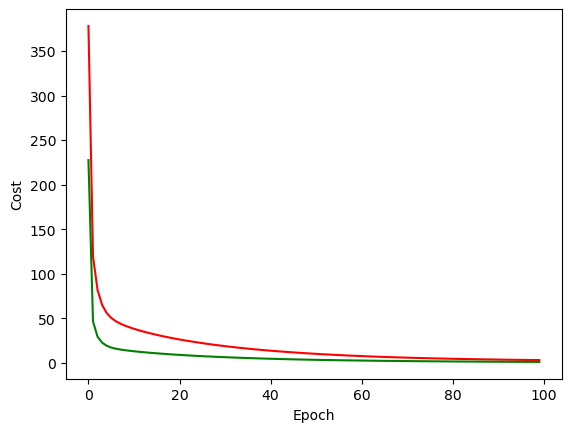

In [26]:
plt.plot(range(epochs), train_cost_hist, 'r-')
plt.plot(range(epochs), val_cost_hist, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Cost')

In [28]:
actual_X = np.transpose(test_X)
actual_y = np.transpose(test_y)
predictions = model.predict(actual_X)

total_examples = actual_y.shape[1]
total_correct = 0
for i in range(0, total_examples):
    predictedDigit = np.argmax(tf.nn.softmax(predictions[:, i]))
    actualDigit = np.argmax(actual_y[:, i])
    if predictedDigit == actualDigit:
        total_correct += 1

print('Accuracy: {}'.format(total_correct / total_examples))

Accuracy: 0.2573
